# Test data retrieval of GeoTIFF and compare to raw DWD data

In [1]:
from osgeo import gdal, osr
import os
import pyproj
from pyproj import Transformer
import logging
import numpy as np
gdal.UseExceptions()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
# move back to main directory

In [4]:
os.chdir('/Users/evandro/PycharmProjects/solest_data_handling/')

In [5]:
parsed_file = './processed_data/dwd/global_irradiation/grids_germany_monthly_radiation_global_202310.tif'

In [6]:
# Freiburg coordinates
fr_lat = 48
fr_lon = 8

In [7]:
def get_value_at_coords(file_path, lat, lon):

    """
    Retrieve the value at specified geographic coordinates from a GeoTIFF file.

    Parameters:
    - file_path: Path to the GeoTIFF file.
    - lat: Latitude of the point.
    - lon: Longitude of the point.

    Returns:
    - Value at the specified coordinates or None if the coordinates are out of the raster bounds.
    """
    
    # Open the dataset
    ds = gdal.Open(file_path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()
    array_data = np.where(array == -999, np.nan, array)
    
    # Get the geo-transform to convert lat/lon to pixel coordinates
    gt = ds.GetGeoTransform()
    
    # Setup transformer to convert from WGS 84 (latitude, longitude) to raster's projection
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:31467", always_xy=True)
    
    # Transform the point
    x, y = transformer.transform(lon, lat)

    # Calculate pixel coordinates
    x_offset = int((x - gt[0]) / gt[1])
    y_offset = int((y - gt[3]) / -gt[5])

    print(x_offset, y_offset)
    print(array_data[-y_offset, x_offset])

    value = array_data[-y_offset, x_offset]

    if value == -999:
        return None  # Missing value
    return value

In [8]:
data = get_value_at_coords(parsed_file, fr_lat, fr_lon)

144 80
71.32


In [9]:
data

71.32

# Plot the data to test

In [10]:
import matplotlib.pyplot as plt

def plot_raster_with_marker(file_path, lat, lon):
    # Open the dataset
    ds = gdal.Open(file_path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()
    array_data = np.where(array == -999, np.nan, array)
    
    # Get the geo-transform to convert lat/lon to pixel coordinates
    gt = ds.GetGeoTransform()
    
    # Setup transformer to convert from WGS 84 (latitude, longitude) to raster's projection
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:31467", always_xy=True)
    
    # Transform the point
    x, y = transformer.transform(lon, lat)
    
    # Calculate pixel coordinates
    x_offset = int((x - gt[0]) / gt[1])
    y_offset = int((y - gt[3]) / -gt[5])

    print(x_offset, y_offset)
    print(array_data[-y_offset, x_offset])

    # Plotting the raster data
    plt.figure(figsize=(10, 8))
    plt.imshow(array_data, cmap='gist_earth', extent=(0, array.shape[1], 0, array.shape[0]))
    plt.colorbar(label='Radiation Value')
    plt.title('Raster Data Visualization with Marked Location')
    plt.xlabel('Pixel X Coordinates')
    plt.ylabel('Pixel Y Coordinates')
    
    # Add a red circle at the x, y coordinates
    plt.scatter([x_offset], [y_offset], color='red', s=5, label=f"Marked Point ({lat}, {lon})")
    plt.legend()

    plt.show()

144 80
71.32


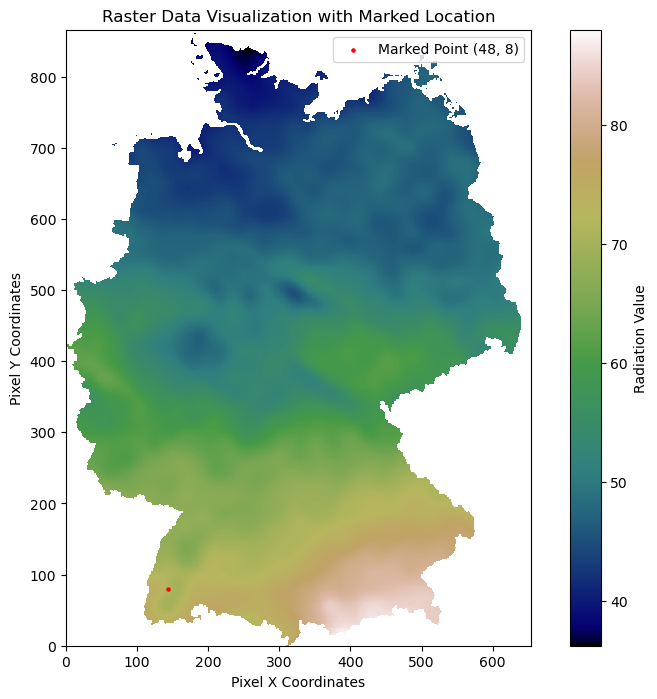

In [11]:
plot_raster_with_marker(parsed_file, fr_lat, fr_lon)